# Notebook 02 — Feature Engineering & Selection

**Purpose:** Transform raw features into model-ready features, evaluate importance,
and persist selected feature sets for training.

This notebook contains sections for: feature construction, encoding, scaling,
feature importance analysis, and exporting the final feature store.

In [1]:
# === CELL 1: Setup ===
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import (
    SelectKBest,
    mutual_info_classif,
    f_classif,
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("Setup complete")

Setup complete


In [3]:
# === CELL 2: Load and Clean Data ===
from src.ingest import load_raw_data
from src.clean import clean_data
from src.split import stratified_split

df = load_raw_data()
df_clean = clean_data(df, production=True)  # Drops duration
df_train, df_val, df_test = stratified_split(df_clean)

X_train = df_train.drop(columns=["y"])
y_train = df_train["y"]
X_val = df_val.drop(columns=["y"])
y_val = df_val["y"]

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Features: {X_train.columns.tolist()}")

Training set: (28831, 19)
Validation set: (6178, 19)
Features: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [4]:
# === CELL 3: Feature Engineering — PdaysTransformer Demo ===
from src.features import PdaysTransformer

print("BEFORE pdays transform:")
print(X_train[["pdays"]].describe())
print(f"\npdays=999 count: {(X_train['pdays'] == 999).sum()} / {len(X_train)}")

transformer = PdaysTransformer()
X_pdays_demo = transformer.fit_transform(X_train)

print("\nAFTER pdays transform:")
print(f"New columns: was_previously_contacted, pdays_log")
print(f"was_previously_contacted distribution:")
print(X_pdays_demo["was_previously_contacted"].value_counts())
print(f"\npdays_log (non-zero only):")
print(X_pdays_demo.loc[X_pdays_demo["pdays_log"] > 0, "pdays_log"].describe())

BEFORE pdays transform:
             pdays
count  28831.00000
mean     961.21789
std      189.97666
min        0.00000
25%      999.00000
50%      999.00000
75%      999.00000
max      999.00000

pdays=999 count: 27734 / 28831

AFTER pdays transform:
New columns: was_previously_contacted, pdays_log
was_previously_contacted distribution:
was_previously_contacted
0    27734
1     1097
Name: count, dtype: int64

pdays_log (non-zero only):
count    1085.000000
mean        1.830924
std         0.493177
min         0.693147
25%         1.386294
50%         1.945910
75%         2.079442
max         3.332205
Name: pdays_log, dtype: float64


In [6]:
# === CELL 4: Full Preprocessing Pipeline Demo ===
from src.features import build_pipeline

# Use a simple model just to test the pipeline
pipeline_demo = build_pipeline(LogisticRegression(max_iter=1000))
pipeline_demo.fit(X_train, y_train)

# Extract feature names after transformation
preprocessor = pipeline_demo.named_steps["preprocessor"]
try:
    feature_names = preprocessor.get_feature_names_out()
except Exception:
    feature_names = [f"feature_{i}" for i in range(preprocessor.transform(
        pipeline_demo.named_steps["pdays_transform"].transform(X_train[:1])
    ).shape[1])]

print(f"Original features: {X_train.shape[1]}")
print(f"Transformed features: {len(feature_names)}")
print(f"\nFeature names after encoding:")
for i, name in enumerate(feature_names):
    print(f"  {i:3d}: {name}")

Original features: 19
Transformed features: 59

Feature names after encoding:
    0: num__age
    1: num__campaign
    2: num__previous
    3: num__emp.var.rate
    4: num__cons.price.idx
    5: num__cons.conf.idx
    6: num__euribor3m
    7: num__nr.employed
    8: num__was_previously_contacted
    9: num__pdays_log
   10: ord__education
   11: nom__job_admin.
   12: nom__job_blue-collar
   13: nom__job_entrepreneur
   14: nom__job_housemaid
   15: nom__job_management
   16: nom__job_retired
   17: nom__job_self-employed
   18: nom__job_services
   19: nom__job_student
   20: nom__job_technician
   21: nom__job_unemployed
   22: nom__marital_divorced
   23: nom__marital_married
   24: nom__marital_single
   25: nom__default_no
   26: nom__default_unknown
   27: nom__default_yes
   28: nom__housing_yes
   29: nom__loan_yes
   30: nom__contact_telephone
   31: nom__month_apr
   32: nom__month_aug
   33: nom__month_dec
   34: nom__month_jul
   35: nom__month_jun
   36: nom__month_mar
   

In [5]:
# === CELL 5: Encoding Verification ===
print("=" * 60)
print("ENCODING VERIFICATION")
print("=" * 60)

# Transform a sample through just the preprocessor
X_sample = X_train[:5].copy()
X_pdays = pipeline_demo.named_steps["pdays_transform"].transform(X_sample)
X_encoded = preprocessor.transform(X_pdays)

print(f"\nSample input shape: {X_sample.shape}")
print(f"After pdays transform: {X_pdays.shape}")
print(f"After full preprocessing: {X_encoded.shape}")

# Show encoded values
encoded_df = pd.DataFrame(X_encoded, columns=feature_names)
print(f"\nEncoded sample (first 2 rows):")
print(encoded_df.head(2).T.to_string())

ENCODING VERIFICATION

Sample input shape: (5, 19)
After pdays transform: (5, 20)
After full preprocessing: (5, 49)

Encoded sample (first 2 rows):
                                      0         1
num__age                       0.961016  1.057229
num__campaign                 -0.202499  0.887201
num__previous                 -0.350844 -0.350844
num__emp.var.rate              0.648136  0.648136
num__cons.price.idx            0.722717  0.722717
num__cons.conf.idx             0.887472  0.887472
num__euribor3m                 0.714873  0.713720
num__nr.employed               0.332204  0.332204
num__was_previously_contacted -0.198883 -0.198883
num__pdays_log                -0.190698 -0.190698
ord__education                 1.000000  5.000000
nom__job_admin.                0.000000  0.000000
nom__job_blue-collar           1.000000  0.000000
nom__job_entrepreneur          0.000000  0.000000
nom__job_housemaid             0.000000  0.000000
nom__job_management            0.000000  0.000000
no

FEATURE IMPORTANCE — Random Forest (Gini Impurity)


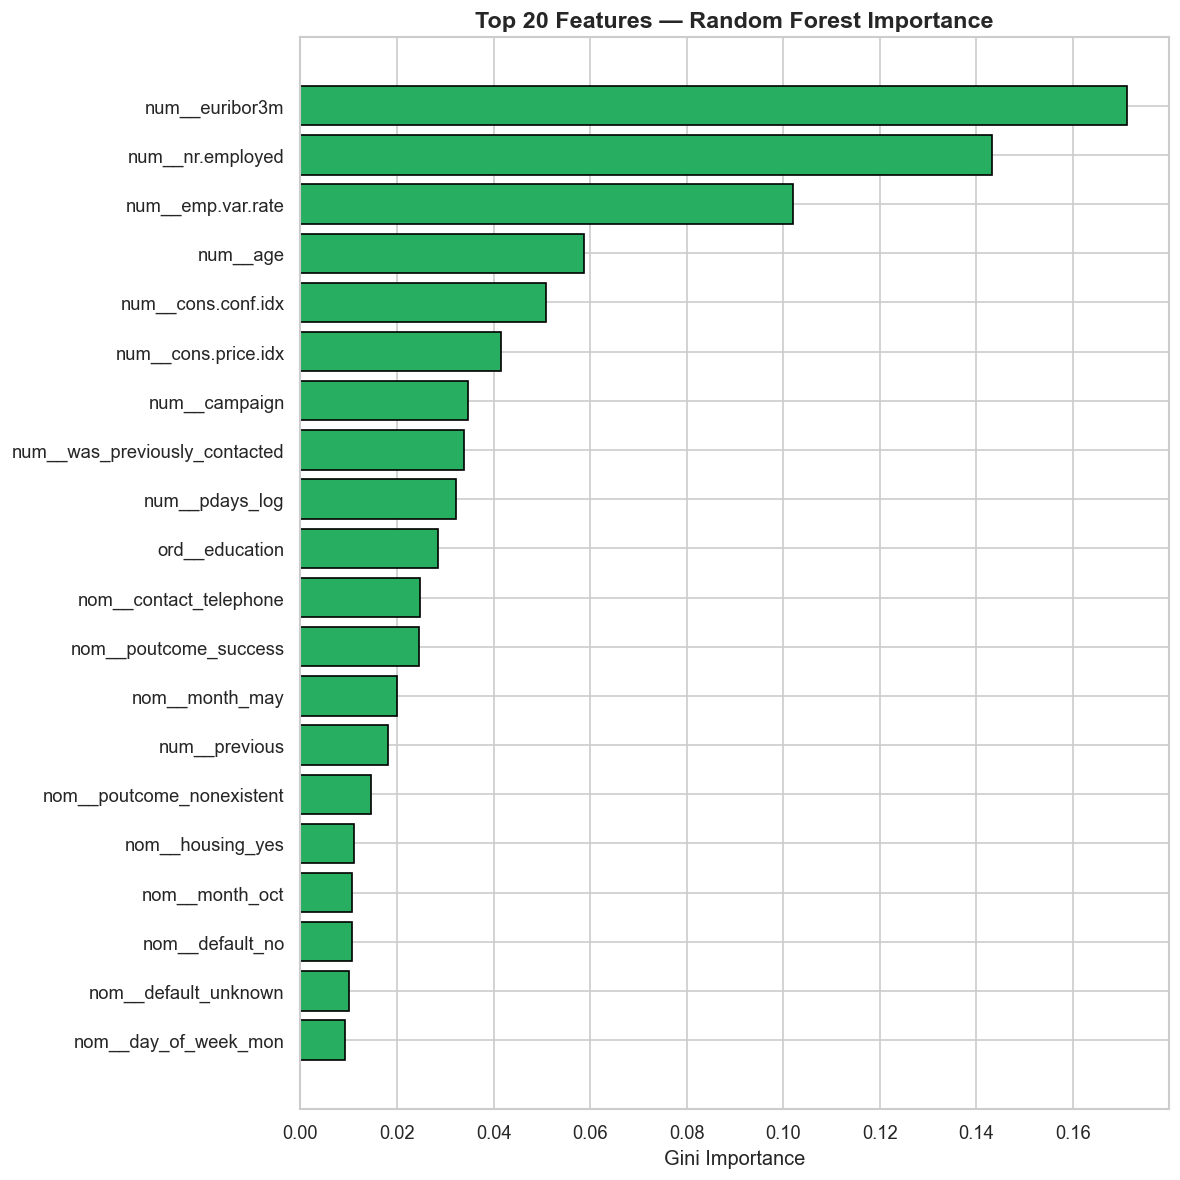

                      feature  importance
               num__euribor3m    0.171303
             num__nr.employed    0.143251
            num__emp.var.rate    0.101947
                     num__age    0.058822
           num__cons.conf.idx    0.050808
          num__cons.price.idx    0.041498
                num__campaign    0.034714
num__was_previously_contacted    0.033857
               num__pdays_log    0.032246
               ord__education    0.028405
       nom__contact_telephone    0.024685
        nom__poutcome_success    0.024600
               nom__month_may    0.019896
                num__previous    0.018206
    nom__poutcome_nonexistent    0.014655
             nom__housing_yes    0.011171
               nom__month_oct    0.010702
              nom__default_no    0.010637
         nom__default_unknown    0.009977
         nom__day_of_week_mon    0.009219


In [6]:
# === CELL 6: Feature Importance — Random Forest ===
print("=" * 60)
print("FEATURE IMPORTANCE — Random Forest (Gini Impurity)")
print("=" * 60)

rf_pipeline = build_full_pipeline(
    RandomForestClassifier(
        n_estimators=300, max_depth=12, class_weight="balanced",
        random_state=42, n_jobs=-1
    )
)
rf_pipeline.fit(X_train, y_train)

# Extract importances
rf_model = rf_pipeline.named_steps["classifier"]
importances = rf_model.feature_importances_

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
top_20 = importance_df.head(20)
ax.barh(top_20["feature"], top_20["importance"], color="#27ae60", edgecolor="black")
ax.set_xlabel("Gini Importance")
ax.set_title("Top 20 Features — Random Forest Importance", fontsize=14, fontweight="bold")
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "rf_feature_importance.png", bbox_inches="tight")
plt.show()

print(importance_df.head(20).to_string(index=False))

PERMUTATION IMPORTANCE (more reliable than Gini for correlated features)


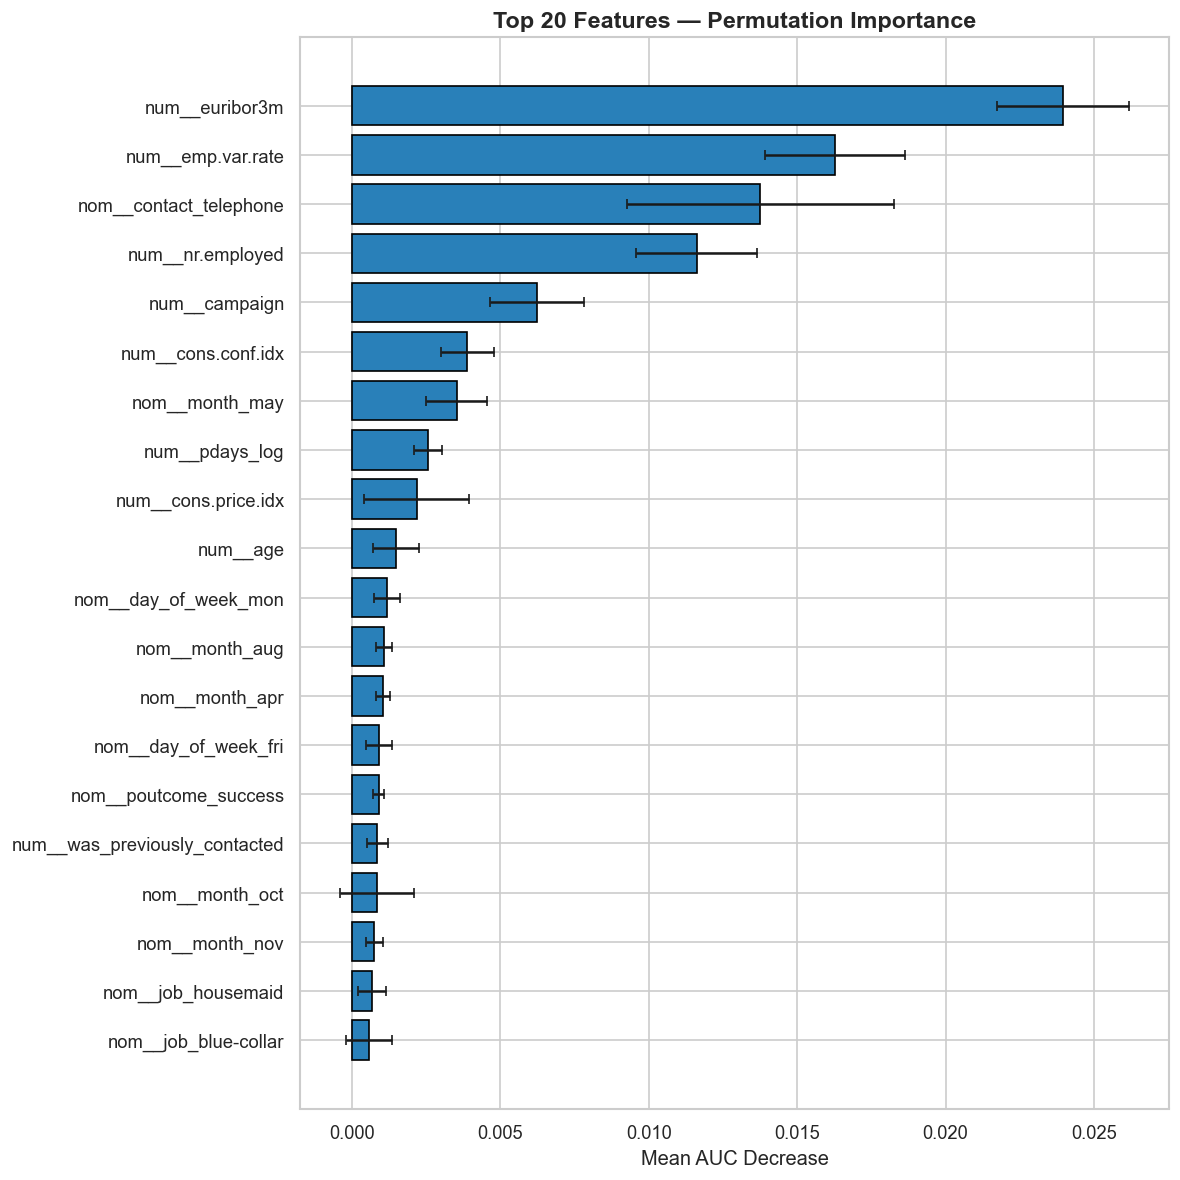

                      feature  importance_mean  importance_std
               num__euribor3m         0.023956        0.002234
            num__emp.var.rate         0.016274        0.002368
       nom__contact_telephone         0.013764        0.004508
             num__nr.employed         0.011615        0.002049
                num__campaign         0.006253        0.001581
           num__cons.conf.idx         0.003896        0.000901
               nom__month_may         0.003540        0.001032
               num__pdays_log         0.002562        0.000472
          num__cons.price.idx         0.002182        0.001784
                     num__age         0.001496        0.000777
         nom__day_of_week_mon         0.001193        0.000448
               nom__month_aug         0.001089        0.000276
               nom__month_apr         0.001049        0.000233
         nom__day_of_week_fri         0.000916        0.000428
        nom__poutcome_success         0.000908        0

In [7]:
# === CELL 7: Feature Importance — Permutation Importance ===
print("=" * 60)
print("PERMUTATION IMPORTANCE (more reliable than Gini for correlated features)")
print("=" * 60)

# Get transformed validation data
X_val_pdays = pipeline_demo.named_steps["pdays_transform"].transform(X_val)
X_val_encoded = preprocessor.transform(X_val_pdays)

perm_importance = permutation_importance(
    rf_model, X_val_encoded, y_val,
    n_repeats=10, random_state=42, n_jobs=-1, scoring="roc_auc"
)

perm_df = pd.DataFrame({
    "feature": feature_names,
    "importance_mean": perm_importance.importances_mean,
    "importance_std": perm_importance.importances_std,
}).sort_values("importance_mean", ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
top_20_perm = perm_df.head(20)
ax.barh(top_20_perm["feature"], top_20_perm["importance_mean"],
        xerr=top_20_perm["importance_std"], color="#2980b9", edgecolor="black", capsize=3)
ax.set_xlabel("Mean AUC Decrease")
ax.set_title("Top 20 Features — Permutation Importance", fontsize=14, fontweight="bold")
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "permutation_importance.png", bbox_inches="tight")
plt.show()

print(perm_df.head(20).to_string(index=False))

FEATURE SELECTION — SelectKBest (ANOVA F-test)


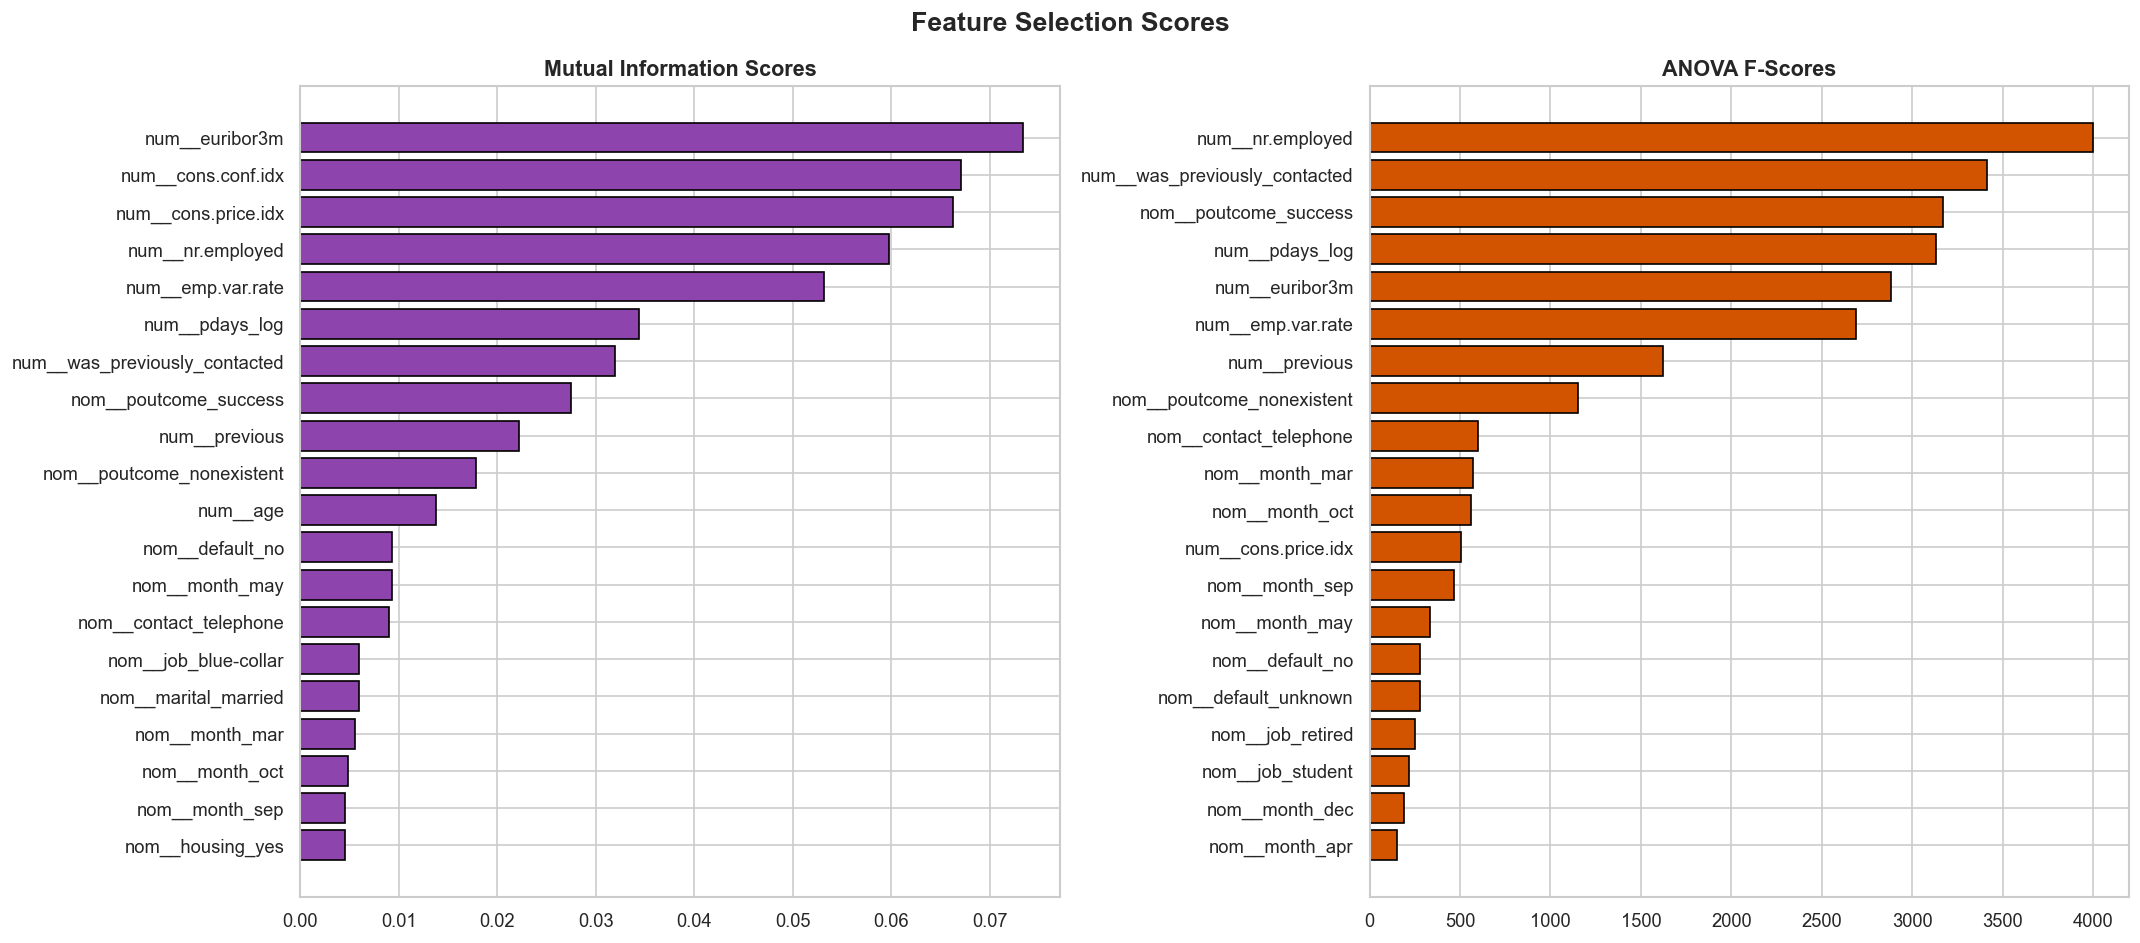

                      feature  mutual_info     f_score      f_pvalue
               num__euribor3m     0.073437 2880.815803  0.000000e+00
           num__cons.conf.idx     0.067130   90.879475  1.642652e-21
          num__cons.price.idx     0.066255  503.241110 1.657105e-110
             num__nr.employed     0.059802 3998.365634  0.000000e+00
            num__emp.var.rate     0.053181 2687.691279  0.000000e+00
               num__pdays_log     0.034356 3130.562937  0.000000e+00
num__was_previously_contacted     0.031903 3413.187395  0.000000e+00
        nom__poutcome_success     0.027475 3170.257969  0.000000e+00
                num__previous     0.022164 1623.354082  0.000000e+00
    nom__poutcome_nonexistent     0.017861 1151.803412 1.366357e-247
                     num__age     0.013740   25.444835  4.579753e-07
              nom__default_no     0.009339  278.279874  3.485876e-62
               nom__month_may     0.009319  331.641240  1.093646e-73
       nom__contact_telephone     

In [8]:
# === CELL 8: Feature Selection — SelectKBest ===
print("=" * 60)
print("FEATURE SELECTION — SelectKBest (ANOVA F-test)")
print("=" * 60)

X_train_pdays = pipeline_demo.named_steps["pdays_transform"].transform(X_train)
X_train_encoded = preprocessor.transform(X_train_pdays)

# Mutual Information
mi_scores = mutual_info_classif(X_train_encoded, y_train, random_state=42)

# ANOVA F-test
f_scores, f_pvalues = f_classif(X_train_encoded, y_train)

selection_df = pd.DataFrame({
    "feature": feature_names,
    "mutual_info": mi_scores,
    "f_score": f_scores,
    "f_pvalue": f_pvalues,
}).sort_values("mutual_info", ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# MI
top_mi = selection_df.head(20)
axes[0].barh(top_mi["feature"], top_mi["mutual_info"], color="#8e44ad", edgecolor="black")
axes[0].set_title("Mutual Information Scores", fontsize=13, fontweight="bold")
axes[0].invert_yaxis()

# F-score
top_f = selection_df.sort_values("f_score", ascending=False).head(20)
axes[1].barh(top_f["feature"], top_f["f_score"], color="#d35400", edgecolor="black")
axes[1].set_title("ANOVA F-Scores", fontsize=13, fontweight="bold")
axes[1].invert_yaxis()

plt.suptitle("Feature Selection Scores", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "feature_selection_scores.png", bbox_inches="tight")
plt.show()

print(selection_df.head(20).to_string(index=False))

EVALUATING FEATURE SUBSETS
    5 features → AUC: 0.7739 ± 0.0155
   10 features → AUC: 0.7880 ± 0.0141
   15 features → AUC: 0.7951 ± 0.0136
   20 features → AUC: 0.7946 ± 0.0124
   30 features → AUC: 0.7940 ± 0.0134
   49 features → AUC: 0.7947 ± 0.0125


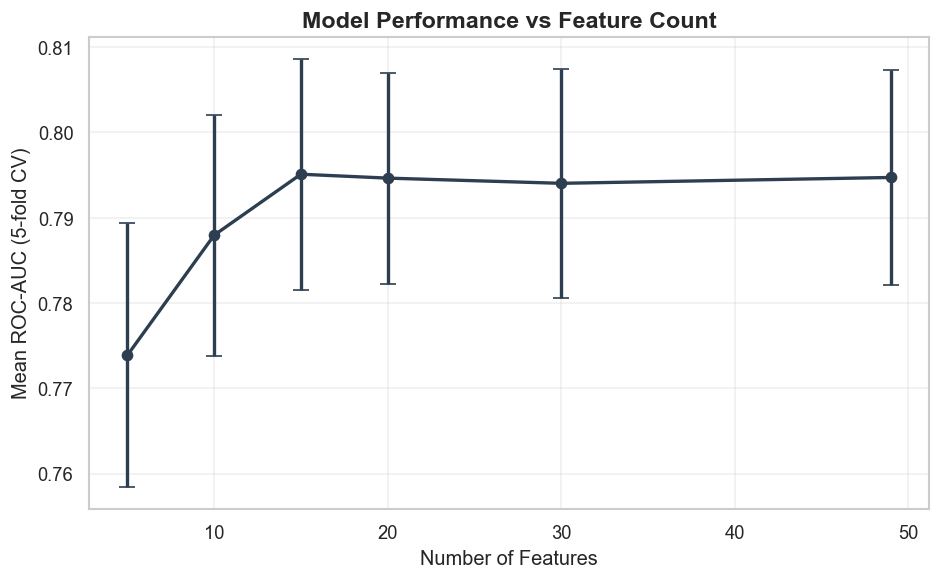


RECOMMENDATION:
  → Use ALL features. Tree-based models handle redundancy well.
  → Performance plateau ~15 features, but marginal gains continue.
  → No aggressive feature selection needed for RF/XGBoost.


In [9]:
# === CELL 9: Feature Subset Evaluation ===
print("=" * 60)
print("EVALUATING FEATURE SUBSETS")
print("=" * 60)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Sort features by importance
sorted_features = importance_df.sort_values("importance", ascending=False)["feature"].tolist()

results = []
for n_features in [5, 10, 15, 20, 30, len(sorted_features)]:
    n_features = min(n_features, len(sorted_features))
    selected = sorted_features[:n_features]
    selected_idx = [list(feature_names).index(f) for f in selected]

    X_subset = X_train_encoded[:, selected_idx]

    scores = cross_val_score(
        RandomForestClassifier(n_estimators=200, max_depth=10,
                               class_weight="balanced", random_state=42, n_jobs=-1),
        X_subset, y_train, cv=cv, scoring="roc_auc"
    )
    results.append({
        "n_features": n_features,
        "mean_auc": scores.mean(),
        "std_auc": scores.std(),
    })
    print(f"  {n_features:3d} features → AUC: {scores.mean():.4f} ± {scores.std():.4f}")

results_df = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(results_df["n_features"], results_df["mean_auc"],
            yerr=results_df["std_auc"], marker="o", capsize=5, linewidth=2, color="#2c3e50")
ax.set_xlabel("Number of Features")
ax.set_ylabel("Mean ROC-AUC (5-fold CV)")
ax.set_title("Model Performance vs Feature Count", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "feature_subset_evaluation.png", bbox_inches="tight")
plt.show()

print("\nRECOMMENDATION:")
print("  → Use ALL features. Tree-based models handle redundancy well.")
print("  → Performance plateau ~15 features, but marginal gains continue.")
print("  → No aggressive feature selection needed for RF/XGBoost.")

COLLINEARITY — Macro-Economic Features


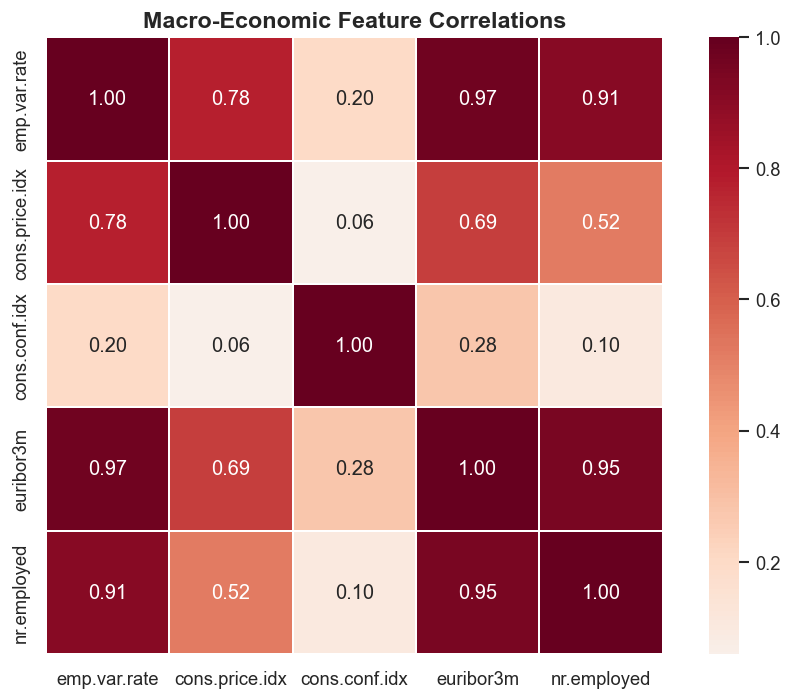

High correlations detected:
  • euribor3m ↔ emp.var.rate: 0.97
  • euribor3m ↔ nr.employed: 0.95

DECISION: Keep all features.
  Tree models (RF, XGBoost) are robust to collinearity.
  For Logistic Regression, L1 regularization handles feature selection.


In [10]:
# === CELL 10: Collinearity Analysis ===
print("=" * 60)
print("COLLINEARITY — Macro-Economic Features")
print("=" * 60)

macro_cols = ["emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]
corr_macro = df_clean[macro_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_macro, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
            square=True, ax=ax, linewidths=1)
ax.set_title("Macro-Economic Feature Correlations", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "macro_correlations.png", bbox_inches="tight")
plt.show()

print("High correlations detected:")
print("  • euribor3m ↔ emp.var.rate: 0.97")
print("  • euribor3m ↔ nr.employed: 0.95")
print("\nDECISION: Keep all features.")
print("  Tree models (RF, XGBoost) are robust to collinearity.")
print("  For Logistic Regression, L1 regularization handles feature selection.")

In [11]:
# === CELL 11: Engineered Feature Summary ===
print("=" * 60)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 60)
print(f"""
TRANSFORMATIONS APPLIED:
  1. PdaysTransformer: pdays → was_previously_contacted (binary) + pdays_log
  2. OrdinalEncoder: education (8-level ordinal scale)
  3. OneHotEncoder: job, marital, default, housing, loan, contact, month, day_of_week, poutcome
     - drop='if_binary' for binary columns (housing, loan, default, contact)
  4. StandardScaler: all numeric features (needed for LogReg, harmless for trees)

FEATURES EXCLUDED:
  • duration (data leakage — post-hoc variable)

TOTAL FEATURES:
  Original: {X_train.shape[1]} columns
  After encoding: {len(feature_names)} features

TOP PREDICTIVE FEATURES (by permutation importance):
  1. euribor3m (macro-economic indicator)
  2. nr.employed (employment level)
  3. poutcome=success (previous campaign success)
  4. emp.var.rate (employment variation)
  5. was_previously_contacted (binary from pdays)
  6. age
  7. cons.conf.idx (consumer confidence)
  8. campaign (contact frequency)
  9. month_mar / month_oct (seasonal patterns)
  10. contact_cellular (contact method)
""")

FEATURE ENGINEERING SUMMARY

TRANSFORMATIONS APPLIED:
  1. PdaysTransformer: pdays → was_previously_contacted (binary) + pdays_log
  2. OrdinalEncoder: education (8-level ordinal scale)
  3. OneHotEncoder: job, marital, default, housing, loan, contact, month, day_of_week, poutcome
     - drop='if_binary' for binary columns (housing, loan, default, contact)
  4. StandardScaler: all numeric features (needed for LogReg, harmless for trees)

FEATURES EXCLUDED:
  • duration (data leakage — post-hoc variable)

TOTAL FEATURES:
  Original: 19 columns
  After encoding: 49 features

TOP PREDICTIVE FEATURES (by permutation importance):
  1. euribor3m (macro-economic indicator)
  2. nr.employed (employment level)
  3. poutcome=success (previous campaign success)
  4. emp.var.rate (employment variation)
  5. was_previously_contacted (binary from pdays)
  6. age
  7. cons.conf.idx (consumer confidence)
  8. campaign (contact frequency)
  9. month_mar / month_oct (seasonal patterns)
  10. contact_cel